## Titanic Disaster Dataset Feature Engineering

This notebook is an attempt towards kick-starting my way around the Titanic dataset to improve my model scores based on feature engineering techniques.
This is not going to be an extensive EDA notebook for viewers, as there are already tons of notebooks available with great amount of EDA to understand the intricacies of the dataset from all aspects.
* We will work with missing value imputations
* We will also try to combine some features with each other to come up with new ones
* We will try to improve our scores by building up on our feature engineering process

In [1]:
# Import the required packages here

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') #Remove warning messages within the kernel

In [2]:
# Import the datasets here
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [3]:
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


In [4]:
# Append the train and test dataframes for data cleaning. 
# We also add a flag so that at a later stage, we can split the combined dataframe to train and test again

train['test_flag'] = 0
test['test_flag'] = 1
df_combined = pd.concat([train, test], axis=0, copy=True)

### High level EDA

We take a look at the % of missing values in each of the features available in the train and test dataset.

_Ignore the missing values in the 'Survived' feature, because of the concatenation the missing values are attributed from the test set_

In [5]:
# Check the % missing values in all the columns of the train set
print(df_combined.isnull().sum()*100/df_combined.shape[0])

# Ignore the missing values for the output class 'Survived' as they are from the test set

PassengerId     0.000000
Survived       31.932773
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.091673
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.076394
Cabin          77.463713
Embarked        0.152788
test_flag       0.000000
dtype: float64


In [6]:
# Subsetting for the list of columns which has less to no missing values

df_subset = df_combined[['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Name', 'Embarked', 'test_flag']]

### Data Cleaning and missing value imputation for the columns

* One of the most common approach to feature engineering has been using the **Name** feature to create a Title feature using regex
* Using the **Cabin** feature to create classes from the initial letter of the column. The nan have been tagged as 'U' or 'Unknown' class in the data
* We'll not use the **Ticket** feature for now, as that feature didn't make quite a lot of sense to me


In [7]:
# Cleaning and level modifications for the categorical features

for dataset in df_subset:
    df_subset['Title'] = df_subset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(df_subset['Title'], df_subset['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,4
Countess,1,0
Don,0,1
Dona,1,0
Dr,1,7
Jonkheer,0,1
Lady,1,0
Major,0,2


In [8]:
for dataset in df_subset:
    df_subset['Title'] = df_subset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
     'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    df_subset['Title'] = df_subset['Title'].replace('Mlle', 'Miss')
    df_subset['Title'] = df_subset['Title'].replace('Ms', 'Miss')
    df_subset['Title'] = df_subset['Title'].replace('Mme', 'Mrs')
    
df_subset[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [9]:
df_subset['Cabin'] = df_subset['Cabin'].replace(np.nan, 'U')
df_subset['Cabin_Class'] = df_subset['Cabin'].astype(str).str[0]

In [10]:
# Remove the columns here, for which we have generated our own classes

df_subset = df_subset.drop(['Ticket', 'Cabin', 'Name'], axis = 1)

### Age

* We find the median of the **Age** feature to impute the missing ages, which is roughly about 20%
* We use the same **Age** column to create buckets of age groups. For _less than 18 (1)_ and for _greater than or equal to 18 (0)_

In [11]:
median_age = df_subset["Age"].median()
df_subset["Age"].fillna(median_age, inplace=True)

In [12]:
df_subset['Age'].describe()

count    1309.000000
mean       29.503186
std        12.905241
min         0.170000
25%        22.000000
50%        28.000000
75%        35.000000
max        80.000000
Name: Age, dtype: float64

In [13]:
df_subset.Age[df_subset.Age < 18] = 1
df_subset.Age[df_subset.Age >= 18] = 0

In [14]:
df_subset['Age'] = df_subset['Age'].astype(int) # Convert the age column to int type to be able to perform operations

### SibSp & Parch

* We use the **Siblings** and the **Parents/Children** features combined to generate a feature called **Family Size**
* Having created a new feature out of the above two, we drop the original features
* We also use the **Family Size** feature to create buckets. _Family Size = 1 (0), Family Size greater than 1 and less than or equal to 4 (1), Family Size greater than 4 (2)_

In [15]:
for dataset in df_subset:
    df_subset['FamilySize'] = df_subset['SibSp'] + df_subset['Parch'] + 1

In [16]:
df_subset = df_subset.drop(['SibSp', 'Parch'], axis = 1)

In [17]:
df_subset.FamilySize[df_subset.FamilySize == 1] = 0
df_subset.FamilySize[(df_subset.FamilySize > 1) & (df_subset.FamilySize <= 4)] = 1
df_subset.FamilySize[(df_subset.FamilySize > 4)] = 2

### Fare

* The **Fare** column has been used to create buckets of Fare class
* Firstly, the missing values (0.07%) are replaced using Median imputation
* The buckets are Fare <= 7.91 (0), Fare > 7.91 and Fare <= 14.454 (1), Fare > 14.454 and Fare <= 31 (2), Fare > 31 (3)
* The Fare buckets have been created based on the percentile of data availabilities

In [18]:
df_subset['Fare'].describe()

count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

In [19]:
df_subset['Fare'].fillna(df_subset['Fare'].dropna().median(), inplace=True)

In [20]:
df_subset.Fare[df_subset.Fare <= 7.91] = 0
df_subset.Fare[(df_subset.Fare > 7.91) & (df_subset.Fare <= 14.454)] = 1
df_subset.Fare[(df_subset.Fare > 14.454) & (df_subset.Fare <= 31)] = 2
df_subset.Fare[df_subset.Fare > 31] = 3
df_subset['Fare'] = df_subset['Fare'].astype(int) # Convert the fare column to integer type

df_subset.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,test_flag,Title,Cabin_Class,FamilySize
0,1,0.0,3,male,0,0,S,0,Mr,U,1
1,2,1.0,1,female,0,3,C,0,Mrs,C,1
2,3,1.0,3,female,0,1,S,0,Miss,U,0
3,4,1.0,1,female,0,3,S,0,Mrs,C,1
4,5,0.0,3,male,0,1,S,0,Mr,U,0


### Embarked

* We do a simple mode imputation in the Embarked feature which attributes to approximately 0.15% missing

In [21]:
mode_embarked = df_subset.Embarked.dropna().mode()[0]
df_subset["Embarked"].fillna(mode_embarked, inplace=True)

In [22]:
print(df_subset.columns)
print(df_subset.head(2))

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked',
       'test_flag', 'Title', 'Cabin_Class', 'FamilySize'],
      dtype='object')
   PassengerId  Survived  Pclass     Sex  Age  Fare Embarked  test_flag Title  \
0            1       0.0       3    male    0     0        S          0    Mr   
1            2       1.0       1  female    0     3        C          0   Mrs   

  Cabin_Class  FamilySize  
0           U           1  
1           C           1  


In [23]:
# One-hot encoding: Pclass, Sex, Age, Fare, Embarked, Title, Cabin_Class, Family Size
# Label encoding:
# Drop:

In [24]:
var = 'Sex'

Sex = df_subset[[var]]
Sex = pd.get_dummies(Sex,drop_first=True)
Sex.head()

,Sex_male
0,1
1,0
2,0
3,0
4,1


In [25]:
var = 'Embarked'

Embarked = df_subset[[var]]
Embarked = pd.get_dummies(Embarked,drop_first=True)
Embarked.head()

,Embarked_Q,Embarked_S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


In [26]:
var = 'Title'

Title = df_subset[[var]]
Title = pd.get_dummies(Title,drop_first=True)
Title.head()

,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,0,1,0,0
1,0,0,1,0
2,1,0,0,0
3,0,0,1,0
4,0,1,0,0


In [27]:
var = 'Cabin_Class'

Cabin_Class = df_subset[[var]]
Cabin_Class = pd.get_dummies(Cabin_Class,drop_first=True)
Cabin_Class.head()

,Cabin_Class_B,Cabin_Class_C,Cabin_Class_D,Cabin_Class_E,Cabin_Class_F,Cabin_Class_G,Cabin_Class_T,Cabin_Class_U
0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1
3,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1


In [28]:
df_subset_int = pd.concat([df_subset, Sex, Embarked, Title, Cabin_Class],axis=1)

In [29]:
df_subset_int.drop(['Sex', 'Embarked', 'Title', 'Cabin_Class'],axis=1,inplace=True)
df_subset_int.head()

,PassengerId,Survived,Pclass,Age,Fare,test_flag,FamilySize,Sex_male,Embarked_Q,Embarked_S,...,Title_Mrs,Title_Rare,Cabin_Class_B,Cabin_Class_C,Cabin_Class_D,Cabin_Class_E,Cabin_Class_F,Cabin_Class_G,Cabin_Class_T,Cabin_Class_U
0,1,0.0,3,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,1
1,2,1.0,1,0,3,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,0
2,3,1.0,3,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,4,1.0,1,0,3,0,1,0,0,1,...,1,0,0,1,0,0,0,0,0,0
4,5,0.0,3,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1


In [30]:
# # In this step, we use the factorize method to factorize the categorical features that we have created above.
# # This is done for model interpretability

# cols_new = ['Embarked', 'Title', 'Sex', 'Cabin_Class']

# for col in cols_new:
#     df_subset[col] = pd.factorize(df_subset[col])[0] + 1
    
# df_subset.head()

In [31]:
# We split the combined dataset to train and test set again

train_set = df_subset_int[df_subset['test_flag']==0]
test_set = df_subset_int[df_subset['test_flag']==1]

train_set['Survived'] = train_set['Survived'].astype(int) # Convert the target feature to integer

In [32]:
# Check if the train and test split was done properly

print(train_set.shape)
print(test_set.shape)

(891, 22)
(418, 22)


In [33]:
# Remove the columns which are not required. Test Flag is not required since we split the data already, and the Survived column is redundant in the test set

test_set = test_set.drop(['Survived', 'test_flag'], axis = 1)
train_set = train_set.drop(['test_flag'], axis = 1)

In [34]:
train_set.head(5)

,PassengerId,Survived,Pclass,Age,Fare,FamilySize,Sex_male,Embarked_Q,Embarked_S,Title_Miss,...,Title_Mrs,Title_Rare,Cabin_Class_B,Cabin_Class_C,Cabin_Class_D,Cabin_Class_E,Cabin_Class_F,Cabin_Class_G,Cabin_Class_T,Cabin_Class_U
0,1,0,3,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,2,1,1,0,3,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
2,3,1,3,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
3,4,1,1,0,3,1,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0
4,5,0,3,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [35]:
train_set = train_set.drop(['PassengerId'], axis = 1)

In [36]:
print(train_set.shape)
print(test_set.shape)

(891, 20)
(418, 20)


In [37]:
from sklearn.model_selection import train_test_split

X = train_set[train_set.columns.drop('Survived')]
y = train_set[['Survived']]

In [38]:
from sklearn.ensemble import ExtraTreesRegressor
selection= ExtraTreesRegressor()
selection.fit(X,y)

ExtraTreesRegressor()

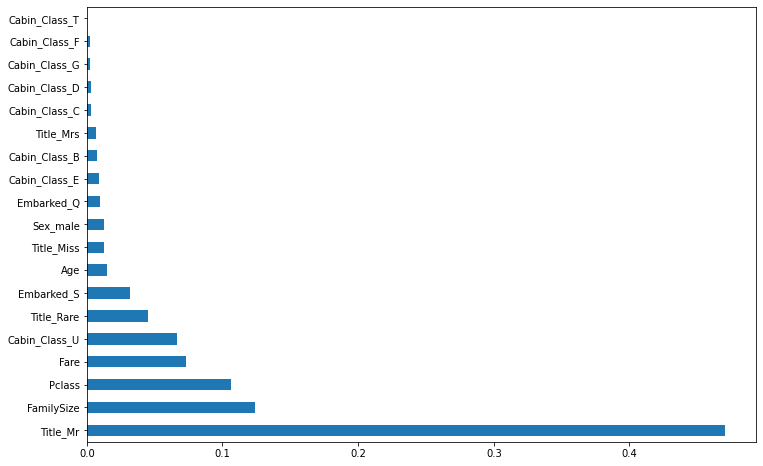

In [39]:
plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

### Model Implementation Process

We use the engineered features into the models to check out the scores. Below are the set of models that we use for this Kernel
1. Logistic Regression
2. Decision Tree
3. Random Forest
4. Naive Bayes

In [122]:
from sklearn.model_selection import train_test_split

X = train_set[['Cabin_Class_T', 'Cabin_Class_F', 'Cabin_Class_G', 'Cabin_Class_C', 
               'Cabin_Class_D', 'Cabin_Class_B', 'Title_Mrs', 'Cabin_Class_E', 'Embarked_Q', 
               'Sex_male', 'Title_Miss', 'Age', 'Embarked_S', 'Title_Rare', 'Cabin_Class_U', 
               'Fare', 'Pclass', 'FamilySize', 'Title_Mr']]
y = train_set[['Survived']]

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(596, 19) (596, 1)
(295, 19) (295, 1)


In [124]:
X_test.head()

,Cabin_Class_T,Cabin_Class_F,Cabin_Class_G,Cabin_Class_C,Cabin_Class_D,Cabin_Class_B,Title_Mrs,Cabin_Class_E,Embarked_Q,Sex_male,Title_Miss,Age,Embarked_S,Title_Rare,Cabin_Class_U,Fare,Pclass,FamilySize,Title_Mr
709,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,2,3,1,0
439,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,2,0,1
840,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,3,0,1
720,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,3,2,1,0
39,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,3,1,0


In [125]:
# Logistic Regression Model

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logistic_model = logreg.fit(X_train, y_train)
predictions = logistic_model.predict(X_test)

acc_logistic_regressions = round(logistic_model.score(X_train, y_train) * 100, 2)
acc_logistic_regressions

83.72

In [126]:
# Decision Tree model
from sklearn.tree import DecisionTreeClassifier

dec_tree = DecisionTreeClassifier()
decision_tree = dec_tree.fit(X_train, y_train)
prediction_tree = decision_tree.predict(X_test)

acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)
acc_decision_tree

89.43

In [139]:
# Random Forest Model

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
random_forest = rf.fit(X_train, y_train)
prediction_forest = random_forest.predict(X_test)

acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
acc_random_forest

89.43

In [97]:
# Naive Bayes

from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gaussian = gnb.fit(X_train, y_train)
prediction_naive = gaussian.predict(X_test)

acc_gaussian = round(gaussian.score(X_train, y_train) * 100, 2)
acc_gaussian

78.19

In [81]:
from catboost import CatBoostClassifier
clf = CatBoostClassifier(
    iterations=10,
#     verbose=5,
)

catboost = clf.fit(X_train, y_train,
    # cat_features=cat_features,
    eval_set=(X_test, y_test),
)

Learning rate set to 0.206726
0:	learn: 0.6175833	test: 0.6130561	best: 0.6130561 (0)	total: 1.12ms	remaining: 10.1ms
1:	learn: 0.5709397	test: 0.5643213	best: 0.5643213 (1)	total: 2.06ms	remaining: 8.24ms
2:	learn: 0.5318682	test: 0.5255601	best: 0.5255601 (2)	total: 2.61ms	remaining: 6.09ms
3:	learn: 0.5067101	test: 0.4978892	best: 0.4978892 (3)	total: 3.4ms	remaining: 5.1ms
4:	learn: 0.4863492	test: 0.4768760	best: 0.4768760 (4)	total: 4.72ms	remaining: 4.72ms
5:	learn: 0.4685996	test: 0.4622661	best: 0.4622661 (5)	total: 5.71ms	remaining: 3.81ms
6:	learn: 0.4529674	test: 0.4461482	best: 0.4461482 (6)	total: 6.35ms	remaining: 2.72ms
7:	learn: 0.4418631	test: 0.4362850	best: 0.4362850 (7)	total: 7.48ms	remaining: 1.87ms
8:	learn: 0.4338814	test: 0.4273640	best: 0.4273640 (8)	total: 8.24ms	remaining: 915us
9:	learn: 0.4264351	test: 0.4217028	best: 0.4217028 (9)	total: 9.09ms	remaining: 0us

bestTest = 0.4217027618
bestIteration = 9



In [82]:
acc_catboost = round(catboost.score(X_train, y_train) * 100, 2)
acc_catboost

83.39

It is observed that the best accuracy is obtained in the Random Forest Model, which we will use to make our submissions to the competition.

### Use the section below to submit on the test set

In [58]:
test_feature = test_set[['Cabin_Class_T', 'Cabin_Class_F', 'Cabin_Class_G', 'Cabin_Class_C', 
               'Cabin_Class_D', 'Cabin_Class_B', 'Title_Mrs', 'Cabin_Class_E', 'Embarked_Q', 
               'Sex_male', 'Title_Miss', 'Age', 'Embarked_S', 'Title_Rare', 'Cabin_Class_U', 
               'Fare', 'Pclass', 'FamilySize', 'Title_Mr']]
test_id = test_set['PassengerId']
test_feature.head()

,Cabin_Class_T,Cabin_Class_F,Cabin_Class_G,Cabin_Class_C,Cabin_Class_D,Cabin_Class_B,Title_Mrs,Cabin_Class_E,Embarked_Q,Sex_male,Title_Miss,Age,Embarked_S,Title_Rare,Cabin_Class_U,Fare,Pclass,FamilySize,Title_Mr
0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,3,0,1
1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,3,1,0
2,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,2,0,1
3,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,3,0,1
4,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,3,1,0


In [140]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest',
             'Naive Bayes', 'Cat Boost'],
    'Score': [acc_logistic_regressions, acc_decision_tree, acc_random_forest,
             acc_gaussian, acc_catboost]})
models.sort_values(by='Score', ascending=False)

,Model,Score
1,Decision Tree,89.43
2,Random Forest,89.43
0,Logistic Regression,83.72
4,Cat Boost,83.39
3,Naive Bayes,78.19


In [65]:
test_predictions = decision_tree.predict(test_feature)

In [66]:
output = pd.DataFrame({'PassengerId' : test_id, 'Survived': test_predictions})
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,1
3,895,0
4,896,0


In [67]:
output.to_csv('/kaggle/working/submission.csv', index=False)

So far, catboost provided the best competition scores for me

In [53]:
# Use this data type conversion for the output feature, if the score comes as 0 in submission

# model.predict(test_data).astype(int)